# Mini Projekt - Baby Kyber

## Pierścień $\mathbb{Z}_{17}[X]/(X^4+1)$

In [13]:
# skopiuj pierścień ilorazowy wielomianów z pierwszych zajęć

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

UPPER_IDS = [8304, 185, 178, 179, 8308, 8309, 8310, 8311, 8312, 8313]


def to_upper_index(number) :
    string = str(number)
    output = ""
    for letter in string:
        output += chr(UPPER_IDS[int(letter)])
    return output

def fix_float(number) :
    return float(number) if not float(number).is_integer() else int(number)

def string_polynomial(poly, variable = 'x') :
    terms = []
    max_power = len(poly) - 1
    for i in range(max_power, -1, -1) :
        if poly[max_power] != 0 : 
            max_power = i
            break
    for i, coeff in enumerate(reversed(poly)) :
        power = len(poly) - i - 1

        if coeff == 0 and max_power != 0 :
            continue
        
        text = ""
        if power == 0 :
            text += f"{fix_float(coeff)}"
        elif power == 1 :
            if coeff == -1 :
                text += f"-"
            elif coeff != 1 :
                text += f"{fix_float(coeff)}"
            text += f"{variable}"
        else :
            if coeff == -1 :
                text += f"-"
            elif coeff != 1 :
                text += f"{fix_float(coeff)}"
            text += f"{variable}{to_upper_index(power)}"
        terms.append(text)
    polynomial = " + ".join(terms)
    polynomial = polynomial.replace("+ -", "- ")

    return polynomial

class ZnW:
    def __init__(self, N, W):
        self.N = N
        self.W = self.moderate(W)
    
    def moderate(self, poly) :
        return Poly([fix_float(x % self.N) for x in poly])
    
    def right_repr(self, poly) :
        
        if isinstance(poly, int) or isinstance(poly, float) : poly = poly % self.N
        else : poly = self.moderate((poly % self.W))

        poly2 = []
        for number in poly:
            poly2.append(fix_float(number))
        return Poly(poly2)
        
    def add(self, poly1, poly2) :
        return self.right_repr(self.right_repr(poly1) + self.right_repr(poly2))
    
    def subtract(self, poly1, poly2) :
        return self.right_repr(self.right_repr(poly1) - self.right_repr(poly2))
    
    def mul(self, poly1, poly2) :
        return self.right_repr(self.right_repr(poly1) * self.right_repr(poly2))

    def div(self, poly1, poly2) :
        return self.right_repr((self.right_repr(poly1) / self.right_repr(poly2))[0])
    
    def __str__(self) :
        return str(self.W)
    
    def __repr__(self) :
        return f"N = {self.N}\nW = " + str(self.W)
   
def is_iterable(value) :
    checker = True
    try :
        value[0]
    except :
        checker = False
    return checker
    

def make_poly(value) :
    if not isinstance(value, Poly) :
        if is_iterable(value) :
            return Poly(value)
        else : return Poly([value])
    return value 


class Poly:
    def __init__(self, poly = None, variable = None) :
        self.poly = poly if poly is not None else [0]
        self.poly.append(0)
        self.variable = variable
        if self.variable is None : self.variable = 'x'
        if len(self.variable) > 1 : self.variable = f"({self.variable})"
        self.trim()

    def normalize(self) :
        while self.poly[-1] == 0 and len(self.poly) > 1 :
            self.poly.pop()

    def __iter__(self):
        self.current = 0
        return self

    def __next__(self):
        if self.current < len(self.poly):
            item = self.poly[self.current]
            self.current += 1
            return item
        else:
            raise StopIteration

    def pop(self, index = -1) :
        self.poly.pop(index)
    
    def trim(self) :
        while self[-1] == 0 and len(self) > 1 :
            self.pop()

    def __getitem__(self, index):
        if isinstance(index, slice) :
            index = slice(min(index.start if index.start is not None else 0, len(self)), min(index.stop if index.stop is not None else len(self), len(self)), index.step)
            addon = [0] * index.start
            return Poly(addon + self.poly[index], self.variable)
        if index >= len(self) : return 0
        return self.poly[index]

    def __setitem__(self, index, value):
        if isinstance(index, slice) :
            index = slice(min(index.start, len(self)), min(index.stop, len(self)), index.step)
            if isinstance(value, Poly):
                self.poly[index] = value.poly
            else:
                self.poly[index] = value if is_iterable(value) else [value] * (index.stop - index.start)
        else:
            if index >= len(self.poly) - 1 : 
                self.poly += [0] * (index - len(self.poly) + 1)
            self.poly[index] = value

    def __len__(self):
        return len(self.poly)
    
    def __add__(poly1, poly2) :
        poly1 = make_poly(poly1)
        poly2 = make_poly(poly2)
        poly = Poly()
        
        for i in range(max(len(poly1), len(poly2))) :
            poly[i] += poly1[i] + poly2[i]
        poly.trim()
        return poly
    
    def __mul__(poly1, poly2) :
        poly1 = make_poly(poly1)
        poly2 = make_poly(poly2)
        
        poly = Poly()
        
        for i in range(len(poly1)) :
            for j in range(len(poly2)) :
                poly[i + j] += poly1[i] * poly2[j]
        poly.trim()
        return poly
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other) :
        return self - other
    
    def __sub__(poly1, poly2) :
        return poly1 + (poly2 * -1)
    
    def __truediv__(poly1, poly2) :
        poly1 = make_poly(poly1)
        poly2 = make_poly(poly2)
        
        poly = deepcopy(poly1)
            
        output = Poly([0] * (len(poly1) - len(poly2) + 1))
        i = len(poly1) - 1
        for i in range(len(poly1) - 1, len(poly2) - 2, -1) :
            index = i - len(poly2) + 1
            output[index] = poly[i] / poly2[-1]
            poly = poly - (poly2 * output[:index + 1])
        
        output.trim()
        poly.trim()
        
        return output, poly
            
    def __floordiv__(poly1, poly2) :
        return (poly1 / poly2)[0]
    
    def __mod__(poly1, poly2) :
        return (poly1 / poly2)[1]
    
    def __eq__(poly1, poly2) :
        if not (isinstance(poly1, Poly) and isinstance(poly2, Poly)) : return False
        check1 = deepcopy(poly1)
        check2 = deepcopy(poly2)
        check1.normalize()
        check2.normalize()
        
        if len(check1) != len(check2) : return False

        for i in range(len(check1)) :
            if check1[i] != check2[i] : return False

        return True        
            
    
    def __str__(self) :
        return string_polynomial(self.poly, self.variable)
    
    def __repr__(self) :
        return self.__str__()
    
def transpose(matrix) :
    n, m = len(matrix), len(matrix[0])
    
    transposed = [[None for _ in range(n)] for _ in range(m)]
    
    for i in range(n) :
        for j in range(m) :
            transposed[j][i] = matrix[i][j]
    
    return transposed
    
def multiply(a, b) :
    return a * b

def add(a, b) :
    return a + b

def sub(a, b) :
    return a - b


def multiply_matrices(matrix1, matrix2, multiply_function = multiply, add_function = add) :
    n1, m1 = len(matrix1), len(matrix1[0])
    n2, m2 = len(matrix2), len(matrix2[0])
    
    if m1 != n2 : raise Exception(f"Unable to multiply matrices due to bad size -> ({n1}, {m1}) x ({n2}, {m2})")
    
    output = [[None for _ in range(m2)] for _ in range(n1)]
    
    for i in range(n1) :
        for j in range(m2) :
            for k in range(m1) :
                value = multiply_function(matrix1[i][k], matrix2[k][j])
                if output[i][j] is None :
                    output[i][j] = value
                else :
                    output[i][j] = add_function(output[i][j], value)
    
    return output
    
def add_matrices(matrix1, matrix2, add_function = add) :
    
    n1, m1 = len(matrix1), len(matrix1[0])
    n2, m2 = len(matrix2), len(matrix2[0])
    
    if n1 != n2 or m1 != m2 :
        raise Exception(f"Unable to add matrices due to bad size -> ({n1}, {m1}) + ({n2}, {m2})")
    
    output = [[None for _ in range(m2)] for _ in range(n1)]
    
    for i in range(n1) :
        for j in range(m2) :
            output[i][j] = add_function(matrix1[i][j], matrix2[i][j])
            
    return output

def subtract_matrices(matrix1, matrix2, subtract_function = sub) :
    return add_matrices(matrix1, matrix2, add_function=subtract_function)

## Baby Kyber

Zaimplementuj poniższe elementy kryptosystemu Baby Kyber tak, aby osiągnąć jak największą skuteczność w testach (przy niezerowych błędach). Wymagana minimalna skuteczność to 60%.

In [14]:
# k = 2
# q = 17
# n = 4
# R = Z[X]/(X^4 + 1)
# R_q = Z_17[X]/(X^4 + 1)

K = 2
N = 4
q = 17
W = Poly([1, 0, 0, 0, 1])
znw = ZnW(q, W)
PROBABILITY = 1e-1

### Generowanie klucza

Zaimplementuj funkcję `key_gen()` realizującą generowanie klucza w kryptosystemie Baby Kyber. Funkcja ma zwracać `A,t,s`. Przetestuj, czy dla podanych $A,s,e$ otrzymasz poprawny wielomian $t$.

$A=\left[\begin{matrix}
    6x^3+16x^2+16x+11&9x^3+4x^2+6x+3\\
    5x^3+3x^2+10x+1&6x^3+x^2+9x+15
\end{matrix}\right]$

$\mathbf{s}=(-x^3-x^2+x,-x^3-x)$

$\mathbf{e}=(x^2,x^2-x)$

$\mathbf{t}=A\mathbf{s}+\mathbf{e}:\ \ \mathbf{t}=(16x^3+15x^2+7,10x^3+12x^2+11x+6)$

In [15]:
def B_ni_1(prop = PROBABILITY):
    random_value = np.random.uniform(0,1)
    if random_value < prop:
        return -1
    if random_value < 2*prop:
        return 1
    return 0


def generate_A():
    return [[Poly(np.random.randint(0, q, size = N).tolist()) for _ in range(K)] for _ in range(K)]

def generate_poly() :
    return [[Poly([B_ni_1() for _ in range(N)])]]

def generate_vector():
    vector = [generate_poly()[0] for _ in range(K)]
    return vector


def calculate_t(A,s,e):
    t = multiply_matrices(A, s, multiply_function=znw.mul, add_function=znw.add)
    t = add_matrices(t, e, add_function=znw.add)
    return t

def key_gen():
    A = generate_A()
    s = generate_vector()
    e = generate_vector()
    t = calculate_t(A,s,e)
    return A,t,s


A = [[Poly([11, 16, 16, 6]), Poly([3, 6, 4, 9])],
     [Poly([1, 10, 3, 5]), Poly([15, 9, 1, 6])]]
s = [[Poly([0, 1, -1, -1])], [Poly([0, -1, 0, -1])]]
e = [[Poly([0, 0, 1, 0])], [Poly([0, -1, 1, 0])]]


t = calculate_t(A,s,e)

model_t = [[Poly([7, 0, 15, 16])], [Poly([6, 11, 12, 10])]]

assert t[0][0] == model_t[0][0]
assert t[1][0] == model_t[1][0]

### Szyfrowanie

Zaimplementuj funkcję `encrypt(A,t,m)` realizującą szyfrowanie w kryptosystemie Baby Kyber a gdzie wejściowe `m` jest w postaci listy. Funkcja ma zwracać szyfrogram `c`. Przetestuj poprawność działania na poniższych danych. 

$m=1\cdot x^3+0\cdot x^2+1\cdot x+1=x^3+x+1$

$\mathbf{r}=(-x^3+x^2,x^3+x^2-1)$

$\mathbf{e_1}=(x^2+x,x^2)$

$e_2=-x^3-x^2$

$\mathbf{u}=A^T\mathbf{r}+\mathbf{e_1}:\ \ \mathbf{u}=(11x^3+11x^2+10x+3,4x^3+4x^2+13x+11)$

$v=\mathbf{t}^T\mathbf{r}+e_2+\lfloor\frac{q}{2}\rceil m:\ \ v=8x^3+6x^2+9x+16$

$\mathbf{c}=(\mathbf{u},v):\ \ \mathbf{c}=((11x^3+11x^2+10x+3,4x^3+4x^2+13x+11),8x^3+6x^2+9x+16)$

In [16]:
def calculate_c(A, t, m, r, e1, e2) :
    u = multiply_matrices(transpose(A), r, multiply_function=znw.mul, add_function=znw.add)
    u = add_matrices(u, e1, add_function=znw.add)
    
    v = multiply_matrices(transpose(t), r, multiply_function=znw.mul, add_function=znw.add)
    v = add_matrices(v, e2, add_function=znw.add)
    v = add_matrices(v, [[m*(int(np.ceil(q/2)))]], add_function=znw.add)
    
    return [u, v]


def encrypt(A, t, m) :
    r = generate_vector()
    e1 = generate_vector()
    e2 = generate_poly()
    
    return calculate_c(A, t, m, r, e1, e2)

model_c = [[[Poly([3, 10, 11, 11])], [Poly([11, 13, 4, 4])]], [[Poly([16, 9, 6, 8])]]]
m = Poly([1, 1, 0, 1])
# print(m)

r = [[Poly([0, 0, 1, -1])], [Poly([-1, 0, 1, 1])]]
# print(r)
    
e1 = [[Poly([0, 1, 1])], [Poly([0, 0, 1])]]
# print(e1)

e2 = [[Poly([0, 0, -1, -1])]]
# print(e2)
# print()
c = calculate_c(A, t, m, r, e1, e2)

assert c[0][0][0] == model_c[0][0][0]
assert c[0][1][0] == model_c[0][1][0]
assert c[1][0][0] == model_c[1][0][0]

### Deszyfrowanie

Zaimplementuj funkcję `decrypt(c,s)` realizującą deszyfrowanie w kryptosystemie Baby Kyber. Funkcja ma zwracać ostateczną odszyfrowaną wiadomość `m_n`. Przetestuj działanie na poniższych danych.

$m_n=v-\mathbf{s}^T\mathbf{u}:\ \ m_n=8x^3+14x^2+8x+6$

$m_n=1\cdot x^3+0\cdot x^2+1\cdot x+1$


In [17]:
def plot_function(probability_function) :
    x = np.linspace(0, q, 500)
    y = [probability_function(i) for i in x]

    plt.plot(x, y, label=f"probability")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.title("Funkcja prawdopodobieństwa")
    plt.legend()
    plt.grid()
    plt.show()  

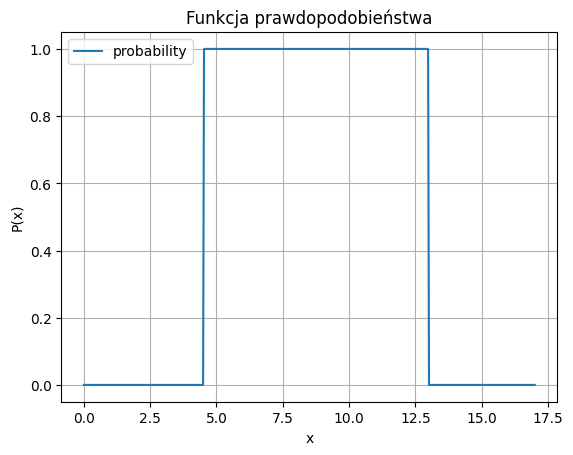

In [18]:
def perfect_probability(x, q = q) :
    to_q2 = np.abs(int(np.ceil(q/2)) - x)
    return 1 if not (np.abs(x) < to_q2 or np.abs(q - x) < to_q2) else 0

plot_function(perfect_probability)

In [19]:
def decrypt(c, s, probability_function = perfect_probability) : 
    
    u, v = c
    value = multiply_matrices(transpose(s), u, multiply_function=znw.mul, add_function=znw.add)
    m_n = subtract_matrices(v, value, subtract_function=znw.subtract)
    poly = m_n[0][0]
    poly.normalize()
    for i in range(len(poly)) :
        val = poly[i]
        randval = np.random.uniform(0, 1)
        if randval <= probability_function(val) :
            poly[i] = 1
        else :
            poly[i] = 0
    
    return poly
    
model_m_n = Poly([1, 1, 0, 1])
    
m_n = decrypt(c, s)

assert m_n == model_m_n

### Testy

In [20]:
import secrets as sc

def test(probability_function = perfect_probability) :
    success = 0
    for i in range(1000):
        A,t,s = key_gen()
        
        m=Poly([sc.choice((0,1)) for _ in range(4)])
        
        c = encrypt(A,t,m)
        m_n = decrypt(c,s, probability_function)
        
        if m_n == m:
            success += 1
    success_rate = success * 100 /1000
    print(f'Success rate: {success_rate} %')
    if 100 > success_rate >= 60 : print("Task complete")
    return success_rate
    
test()

Success rate: 99.9 %
Task complete


99.9

In [21]:
def normal_distribution(mu, sigma) :
    def probability(x) :
        return (1/ (sigma * np.sqrt(2 * np.pi)))*(np.exp(-(np.pow(x - mu, 2)/(2*np.pow(sigma, 2)))))
    
    return probability

In [22]:
def probability_function_from_normal_distribution(mu, sigma) :
    func = normal_distribution(mu, sigma)
    
    return lambda x : func(x) / func(mu)

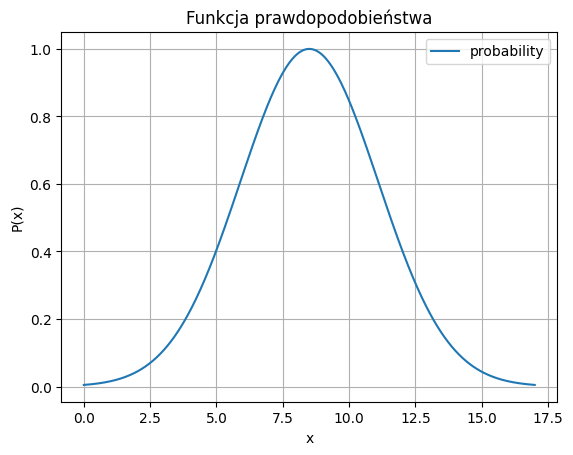

Success rate: 85.0 %
Task complete


85.0

In [23]:
prob1 = probability_function_from_normal_distribution(q/2, 2.6)
    
plot_function(prob1)

test(prob1)

In [24]:
def probability_function_from_rational_function(a, q = N) :
    
    return lambda x : 1/( (np.pow((4/q)*(x - (q/2)), 2*a)) + 1 )

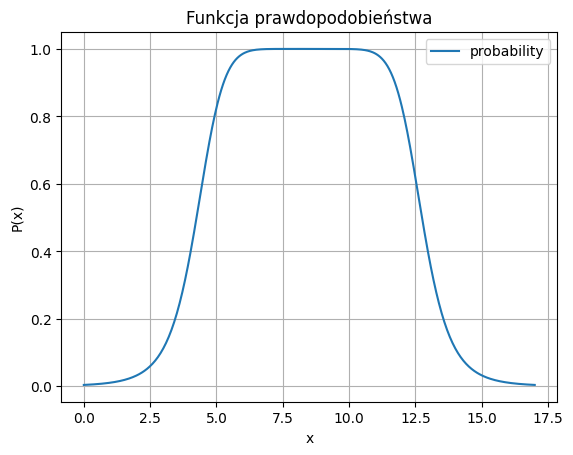

Success rate: 97.1 %
Task complete


97.1

In [25]:
prob3 = probability_function_from_rational_function(4, q)
    
plot_function(prob3)

test(prob3)